# Causal Inference in Decision Intelligence – Part 15: Quantifying Causal Influence

Link to the article:  [Quantifying Causal Influence](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-15-eugene-zinoviev-fsfkc)

## Generate the data

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
from collections import OrderedDict
import warnings

import numpy as np
import pandas as pd
import networkx as nx

import dowhy.gcm as gcm
from dowhy.utils import plot

from dowhy import CausalModel
from dowhy.gcm.falsify import falsify_graph, FalsifyConst, plot_local_insights, run_validations, apply_suggestions

from scipy import linalg 
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})
#data["Income"] = data.Income.replace({1: "Low", 2: "Medium", 3: "High"})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create Promo variable 
data['Market'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Market + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + np.random.normal(loc=0, scale=5, size=4000)

data.sample(20)

,Year,Id,Income,Macro,Price,Market,Visits,Sales
51,2020,52,1,1,11.592328,71.577206,7.032273,70.604988
3582,2023,583,1,0,10.382522,83.363589,8.430654,59.308193
1130,2021,131,1,0,10.373959,83.608966,8.147304,55.085361
2927,2022,928,1,1,11.175317,73.532787,7.125739,69.324000
23,2020,24,1,1,11.020734,71.208528,7.699894,73.250583
3444,2023,445,3,0,10.199208,81.610936,8.890104,81.918829
1250,2021,251,3,0,10.080402,81.157260,8.391234,90.926518
2410,2022,411,3,1,12.040938,73.520657,7.711044,105.036159
1451,2021,452,1,0,9.687792,80.856476,8.187418,61.902019
1148,2021,149,2,0,9.959539,81.986081,7.272279,69.457665


## Build Graphical Causal Model (GCM)

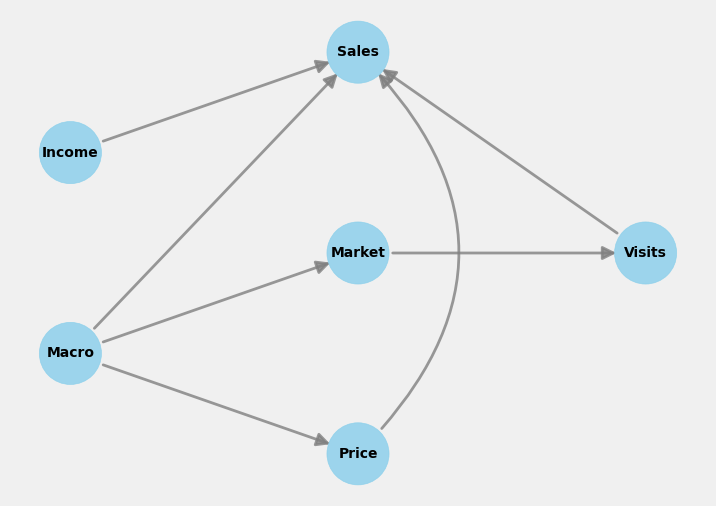

In [3]:
# Create the true DAG
G_part = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Market'), 
                  ('Income', 'Sales'), ('Price', 'Sales'), ('Market', 'Visits'), ('Visits', 'Sales')])
plt.rcParams['font.size'] = 10
plot(G_part, figure_size=[8, 6])

In [4]:
# Build Structural causal model on top of the causal graph
np.random.seed(3)
causal_model = gcm.StructuralCausalModel(G_part)

In [5]:
np.random.seed(3)
# Assign causal mechanisms to each node
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

In [6]:
# Fit the graphical causal model
np.random.seed(3)
gcm.fit(causal_model, data)

Fitting causal mechanism of node Visits: 100%|███████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


## Quatify Arrow Strength

In [7]:
# Create a function to convert the strength to percentage
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

In [8]:
# Quantify arrow strength
strength = gcm.arrow_strength(causal_model, 'Sales')
strength

{('Income', 'Sales'): 105.5436063502585,
 ('Macro', 'Sales'): 196.72423666922518,
 ('Price', 'Sales'): 62.47264346840609,
 ('Visits', 'Sales'): 8.495373059842688}

In [9]:
# Convert the arrows strength to percentage
convert_to_percentage(strength)

{('Income', 'Sales'): 28.277991958798033,
 ('Macro', 'Sales'): 52.70775345852492,
 ('Price', 'Sales'): 16.738113948672336,
 ('Visits', 'Sales'): 2.2761406340047103}

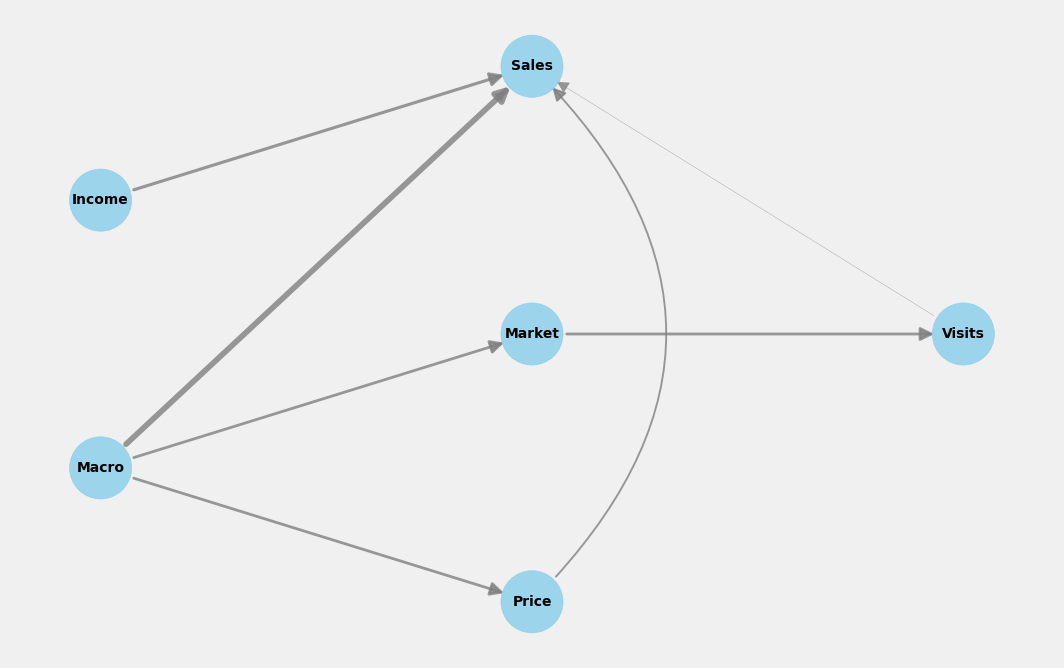

In [10]:
# Plot the arrow strength
from dowhy.utils import plot
plot(G_part,
     causal_strengths=convert_to_percentage(strength),
     figure_size=[12, 8])

## Quantify Intrinsic Causal Influence

In [11]:
# Quantify intrinsic causal inference
contributions = gcm.intrinsic_causal_influence(causal_model, 'Sales')
contributions

Evaluating set functions...: 100%|█████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.53it/s]


{'Macro': 24.237256236314483,
 'Income': 104.01598558801976,
 'Price': 11.977974543361002,
 'Market': 0.32836174832702913,
 'Visits': 3.40272660378002,
 'Sales': 20.945091572347646}

In [12]:
# Convert contributions to percentage
convert_to_percentage(contributions)

{'Macro': 14.697494946421783,
 'Income': 63.075391357065044,
 'Price': 7.263455013346292,
 'Market': 0.19911887259762648,
 'Visits': 2.0634166085260053,
 'Sales': 12.701123202043235}

<Figure size 1000x600 with 0 Axes>

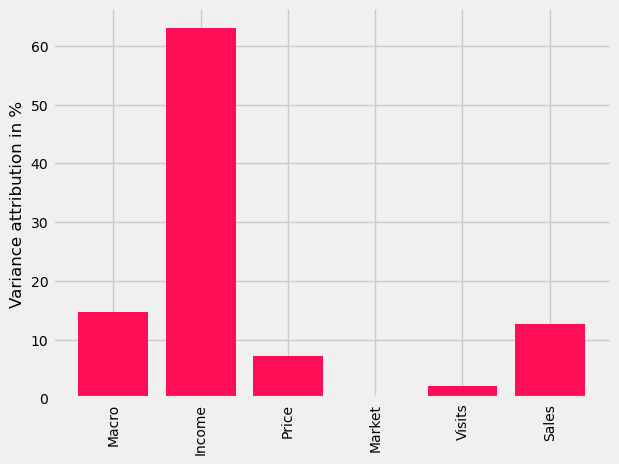

In [16]:
# Plot the percentage contribution of each variable
from dowhy.utils import bar_plot
plt.figure(figsize=(10,6))
bar_plot(convert_to_percentage(contributions), ylabel='Variance attribution in %')